In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r"C:\Users\USER\Documents\Tradingstuff\IV_PI_Stratdf_for_training.csv")
df.set_index('Unnamed: 0',inplace=True)
df

,high,low,close_price,volume,log_return,smoothed_IV,min_max_PI,rolling_std_30,rolling_annual_vol_30,Vol_Spread,...,long_RSI,RSI_diff,MACD_Line,MACD_Signal,MACD_Histogram,Vol_Spread_ROC,Vol_Spread_RSI,Vol_Spread_MACD,Vol_Spread_Signal,Vol_Spread_MACD_Hist
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2023-07-30 14:00:00,29391.82,29381.13,29391.81,33.27224,0.003541,35.33,-0.000273,0.002939,27.505899,7.824101,...,51.711811,-22.383681,1.951589,-2.217337,4.168926,0.270454,78.532975,0.479000,0.310619,0.168381
2023-07-30 15:00:00,29349.37,29349.36,29349.37,5.54135,-0.001445,35.24,-0.000876,0.002939,27.508929,7.731071,...,47.436856,-14.262119,4.338682,-0.906133,5.244815,0.248834,75.729101,0.546664,0.357828,0.188836
2023-07-30 16:00:00,29385.67,29375.99,29380.02,39.36677,0.001044,35.76,-0.000683,0.002910,27.239903,8.520097,...,50.755406,-18.931974,8.604481,0.995990,7.608492,0.422478,79.527923,0.656389,0.417540,0.238849
2023-07-30 17:00:00,29396.52,29396.51,29396.52,1.47595,0.000561,35.82,-0.000651,0.002910,27.232957,8.587043,...,54.086696,-17.382354,13.164815,3.429755,9.735060,0.409577,80.409140,0.740217,0.482076,0.258141
2023-07-30 18:00:00,29356.00,29354.99,29355.99,5.72125,-0.001380,35.79,-0.000752,0.002908,27.215382,8.574618,...,54.941333,-2.553402,13.354536,5.414711,7.939825,0.419616,83.735404,0.796467,0.544954,0.251513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-08 08:00:00,86112.50,86070.77,86071.57,10.03545,-0.001458,52.12,-0.000815,0.006723,62.928420,-10.808420,...,41.538452,-7.389541,-665.638390,-645.015626,-20.622764,0.286658,0.000000,-1.549088,-1.453640,-0.095447
2025-03-08 09:00:00,85943.29,85889.54,85943.28,5.34728,-0.001492,52.04,-0.000826,0.006721,62.904620,-10.864620,...,40.333841,-2.528123,-663.997329,-648.811967,-15.185362,0.268106,0.000000,-1.561960,-1.475304,-0.086656
2025-03-08 10:00:00,86140.51,86121.91,86123.19,2.67768,0.002091,51.89,-0.000839,0.006720,62.892348,-11.002348,...,41.500236,-14.964508,-640.792881,-647.208150,6.415268,0.238633,0.000000,-1.565233,-1.493290,-0.071943


In [3]:
horizons = [4,6,8,10,12,14,16]  # for instance

threshold_return = 0.02  # 2%

for h in horizons:
    # Compute forward log return: ln(P[t+h] / P[t])
    df[f'fwd_ret_{h}'] = np.log(df['close_price'].shift(-h) / df['close_price'])
    
    # Create a ternary label:
    # 1 if forward log return > 2%, -1 if forward log return < -2%, otherwise 0.
    conditions = [
        df[f'fwd_ret_{h}'] > threshold_return,
        df[f'fwd_ret_{h}'] < -threshold_return
    ]
    choices = [1, -1]
    df[f'label_{h}'] = np.select(conditions, choices, default=0)

# Because the last h rows are NaN for fwd_ret, drop rows with NaN in any fwd_ret column
df.dropna(subset=[f'fwd_ret_{h}' for h in horizons], how='all', inplace=True)

# Print statistics for each horizon
for h in horizons:
    ret_col = f'fwd_ret_{h}'
    label_col = f'label_{h}'
    
    # Filter out rows where this horizon is NaN
    valid_rows = df[ret_col].dropna()
    
    if valid_rows.empty:
        print(f"No valid data for horizon {h}, skipping...\n")
        continue
    
    print(f"=== Horizon {h} ===")
    print(f"Forward Log Return '{ret_col}' Stats:\n", valid_rows.describe())
    
    # Label distribution
    label_mean = df.loc[valid_rows.index, label_col].mean()
    label_counts = df.loc[valid_rows.index, label_col].value_counts().sort_index()
    
    print(f"\nLabel '{label_col}' Distribution:")
    print(f" - Proportion of 1: {(df.loc[valid_rows.index, label_col] == 1).mean():.2%}")
    print(f" - Proportion of -1: {(df.loc[valid_rows.index, label_col] == -1).mean():.2%}")
    print(f" - Proportion of 0: {(df.loc[valid_rows.index, label_col] == 0).mean():.2%}")
    print(f" - Count of labels:\n{label_counts}")
    
    print("\n" + "-"*40 + "\n")

=== Horizon 4 ===
Forward Log Return 'fwd_ret_4' Stats:
 count    14083.000000
mean         0.000305
std          0.010498
min         -0.086963
25%         -0.003888
50%          0.000193
75%          0.004519
max          0.093313
Name: fwd_ret_4, dtype: float64

Label 'label_4' Distribution:
 - Proportion of 1: 3.47%
 - Proportion of -1: 3.07%
 - Proportion of 0: 93.46%
 - Count of labels:
label_4
-1      432
 0    13162
 1      489
Name: count, dtype: int64

----------------------------------------

=== Horizon 6 ===
Forward Log Return 'fwd_ret_6' Stats:
 count    14081.000000
mean         0.000459
std          0.012818
min         -0.104602
25%         -0.004763
50%          0.000305
75%          0.005738
max          0.102885
Name: fwd_ret_6, dtype: float64

Label 'label_6' Distribution:
 - Proportion of 1: 5.33%
 - Proportion of -1: 4.79%
 - Proportion of 0: 89.88%
 - Count of labels:
label_6
-1      675
 0    12656
 1      750
Name: count, dtype: int64

------------------------

In [5]:
print(df.columns.tolist())

['high', 'low', 'close_price', 'volume', 'log_return', 'smoothed_IV', 'min_max_PI', 'rolling_std_30', 'rolling_annual_vol_30', 'Vol_Spread', 'rolling_mean_PI', 'rolling_std_PI', 'z_score_PI', 'rol_mean_Vol_Spread', 'rol_std_Vol_Spread', 'z_score_Vol_Spread', 'PI_VolSpread_zdiff', 'label_4', 'label_6', 'label_8', 'label_10', 'label_12', 'label_14', 'label_16', 'smoothed_IV_lag_1', 'smoothed_IV_lag_2', 'smoothed_IV_lag_3', 'smoothed_IV_lag_4', 'smoothed_IV_lag_5', 'smoothed_IV_lag_6', 'min_max_PI_lag_1', 'min_max_PI_lag_2', 'min_max_PI_lag_3', 'min_max_PI_lag_4', 'min_max_PI_lag_5', 'min_max_PI_lag_6', 'Vol_Spread_lag_1', 'Vol_Spread_lag_2', 'Vol_Spread_lag_3', 'Vol_Spread_lag_4', 'Vol_Spread_lag_5', 'Vol_Spread_lag_6', 'ROC', 'Williams_%R', 'MFI', 'OBV', 'Force_Index', 'Volume_ROC', 'short_RSI', 'long_RSI', 'RSI_diff', 'MACD_Line', 'MACD_Signal', 'MACD_Histogram', 'Vol_Spread_ROC', 'Vol_Spread_RSI', 'Vol_Spread_MACD', 'Vol_Spread_Signal', 'Vol_Spread_MACD_Hist', 'fwd_ret_4', 'fwd_ret_6'

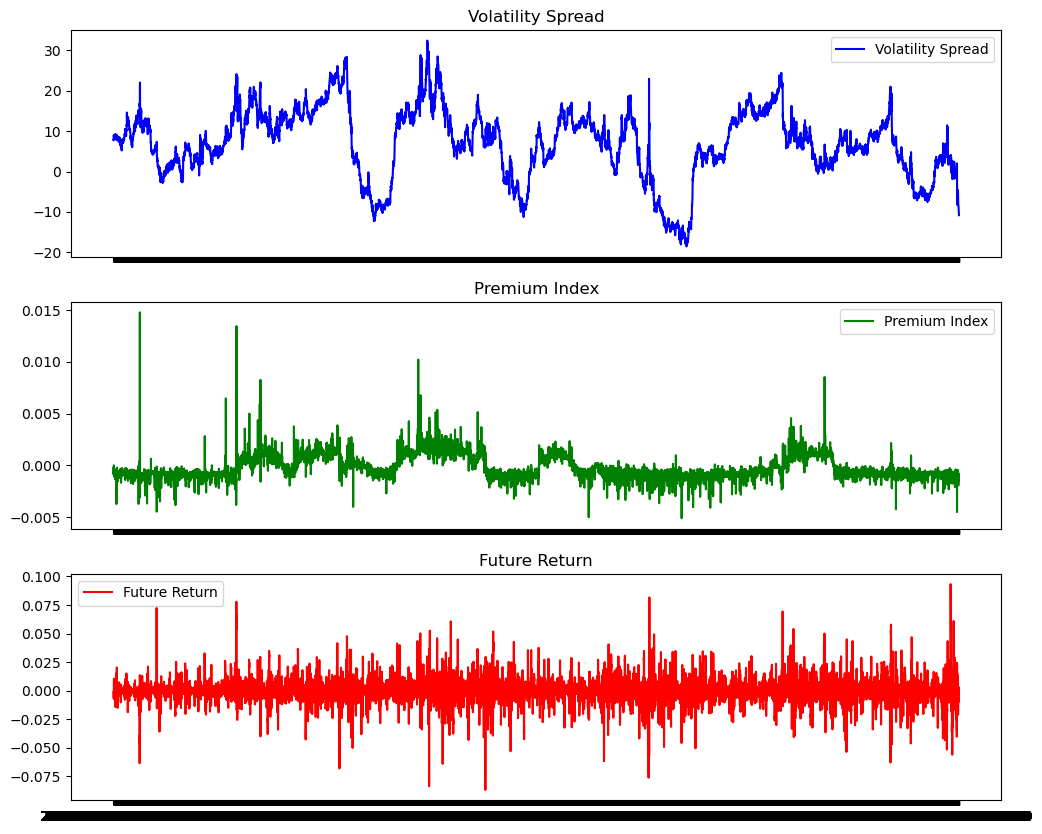

In [6]:
# Plot the features alongside the future return
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

axes[0].plot(df.index, df['Vol_Spread'], color='blue', label='Volatility Spread')
axes[0].set_title('Volatility Spread')
axes[0].legend()

axes[1].plot(df.index, df['min_max_PI'], color='green', label='Premium Index')
axes[1].set_title('Premium Index')
axes[1].legend()

axes[2].plot(df.index, df['fwd_ret_4'], color='red', label='Future Return')
axes[2].set_title('Future Return')
axes[2].legend()
